In [3]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from PIL import Image

from bs4 import BeautifulSoup 
import networkx as nx 

import pickle

import warnings

In [11]:
phish_data = pd.read_csv('phishing_site_urls.csv')

In [12]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [13]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

In [14]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

### Preprocessing

In [16]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [17]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [18]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [19]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 4.962391800014302 sec


In [20]:
phish_data.sample(5)

,URL,Label,text_tokenized
493720,pashaescobar.com/y822/s4gkd5.php,bad,"[pashaescobar, com, y, s, gkd, php]"
290276,benchfly.com/blog/scientist-turned-comedian-ti...,good,"[benchfly, com, blog, scientist, turned, comed..."
361633,indiadivine.org/audarya/hinduism-forum/42639-s...,good,"[indiadivine, org, audarya, hinduism, forum, s..."
70657,www.flexatone.net/algoNet/,good,"[www, flexatone, net, algoNet]"
148604,belanger.wordpress.com/,good,"[belanger, wordpress, com]"


In [21]:
stemmer = SnowballStemmer("english") # choose a language

In [22]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 123.11943130000145 sec


In [32]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
133130,gulftires.com/admin/upload/catalog/aliexpress....,bad,"[gulftires, com, admin, upload, catalog, aliex...","[gulftir, com, admin, upload, catalog, aliexpr...",gulftir com admin upload catalog aliexpress lo...
85593,www.pcworld.com/article/79563/lindowscom_looks...,good,"[www, pcworld, com, article, lindowscom, looks...","[www, pcworld, com, articl, lindowscom, look, ...",www pcworld com articl lindowscom look to dism...
516551,shagagy21.no-ip.biz:1605,bad,"[shagagy, no, ip, biz]","[shagagi, no, ip, biz]",shagagi no ip biz
4531,telac.be/data/remax/index.htm,bad,"[telac, be, data, remax, index, htm]","[telac, be, data, remax, index, htm]",telac be data remax index htm
479271,zillow.com/homedetails/2712-Maxwell-Ave-Oaklan...,good,"[zillow, com, homedetails, Maxwell, Ave, Oakla...","[zillow, com, homedetail, maxwel, ave, oakland...",zillow com homedetail maxwel ave oakland ca zpid


In [33]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.6502319000137504 sec


In [34]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
176706,en.wikipedia.org/wiki/KCSM_(FM),good,"[en, wikipedia, org, wiki, KCSM, FM]","[en, wikipedia, org, wiki, kcsm, fm]",en wikipedia org wiki kcsm fm
305672,clarkart.edu/research/content.cfm?ID=42,good,"[clarkart, edu, research, content, cfm, ID]","[clarkart, edu, research, content, cfm, id]",clarkart edu research content cfm id
463023,westernclippings.com/westernsof/bobsteelept1_w...,good,"[westernclippings, com, westernsof, bobsteelep...","[westernclip, com, westernsof, bobsteelept, we...",westernclip com westernsof bobsteelept western...
406549,nosorigines.qc.ca/genealogieQuebec.aspx?Geneal...,good,"[nosorigines, qc, ca, genealogieQuebec, aspx, ...","[nosorigin, qc, ca, genealogiequebec, aspx, ge...",nosorigin qc ca genealogiequebec aspx genealog...
261162,wn.com/Pierre_Gauvreau,good,"[wn, com, Pierre, Gauvreau]","[wn, com, pierr, gauvreau]",wn com pierr gauvreau


In [35]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [36]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [37]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [38]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [39]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [44]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [51]:
import webdriver
browser = webdriver.Chrome(r"chromedriver.exe")

ModuleNotFoundError: No module named 'webdriver'

In [47]:
list_urls = ['https://www.ezeephones.com/','https://www.ezeephones.com/about-us'] #here i take phishing sites 
links_with_text = []

In [48]:
for url in list_urls:
    browser.get(url)
    soup = BeautifulSoup(browser.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

NameError: name 'browser' is not defined

In [49]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])

In [50]:
df.head()

,from,to


In [52]:
#create cv object
cv = CountVectorizer()

In [53]:
#help(CountVectorizer())

In [54]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [55]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

In [57]:
# create lr object
lr = LogisticRegression()

In [58]:
lr.fit(trainX,trainY)

C:\Users\My\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
lr.score(testX,testY)

0.9638480526005374

In [60]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9780781487783033
Testing Accuracy : 0.9638480526005374

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.93     36824
        Good       0.99      0.96      0.98    100513

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


<Axes: >

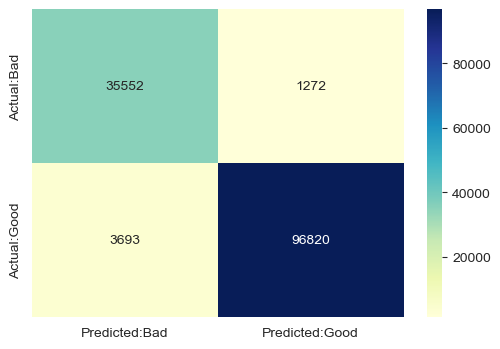

In [61]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [67]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+) -- these tolenizers giving me low accuray 

In [68]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

C:\Users\My\AppData\Local\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
pipeline_ls.score(testX,testY) 

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)